In [21]:
import numpy as np
import scipy
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils.compl_cal import compl_mul, compl_div
from utils.PINNnet import sine_init, first_layer_sine_init, PINN
from utils.plot_func import plot_field, model_pred, plot_error_field

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [22]:
# fixed parameters
L = 1
Lx, Ly = L, L
src = [0, 0]
k = 20

In [25]:
## hyperparameter
n_in = 2 
n_out = 2
n_hiddens = 256
n_layers = 5
n_epochs = int(2e2)
learning_rate = 2e-5

In [26]:
def loss_grad_norm(loss, model):
    loss_grad_norm = 0
    loss_clone = loss.clone()
    for params in model.parameters():
        loss_grad = torch.autograd.grad(loss_clone, params, retain_graph=True, allow_unused=True, materialize_grads=True)[0]
        loss_grad_norm += torch.sum(loss_grad**2)
    loss_grad_norm = loss_grad_norm**0.5
    loss_grad_norm = loss_grad_norm.detach()
    return loss_grad_norm

def update_lambda(model, loss_lst, lamb_lst, alpha):
    grad = []
    for loss in loss_lst:
        grad.append(loss_grad_norm(loss, model))
    grad_sum = sum(grad)
    lamb = []
    for i in range(len(grad)):
        lamb_hat = grad_sum / grad[i]
        if torch.isnan(lamb_hat) or torch.isinf(lamb_hat):
            lamb_hat = torch.ones_like(lamb_hat)
        lamb_new = alpha*lamb_lst[i] + (1-alpha)*lamb_hat
        lamb.append(lamb_new)
    return lamb

In [27]:
class get_dataset(Dataset):
    def __init__(self, k, src=[0., 0.], std=0.01, n_samples=100000, n_bound_samples=500):
        super().__init__()
        self.k = k
        self.std = std
        self.n_src = 5000
        self.n_samples = n_samples
        self.n_bound = n_bound_samples
        self.src = src

    def green(self, x, y, is_tensor=True):
        if is_tensor:
            r = torch.sqrt((x-self.src[0]) ** 2 + (y-self.src[1]) ** 2)
            r = r.to('cpu').detach().numpy()
            hankel = scipy.special.hankel2(0, self.k * r + 1e-6)
            g = 0.25j * hankel
            g_real, g_imag = g.real, g.imag
            g_real, g_imag = torch.tensor(g_real), torch.tensor(g_imag)
            g = torch.cat([g_real, g_imag], dim=-1)
        else:
            r = np.sqrt((x-self.src[0]) ** 2 + (y-self.src[1]) ** 2)
            hankel = scipy.special.hankel2(0, self.k * r + 1e-6)
            g = 0.25j * hankel
            g_real, g_imag = g.real, g.imag
            g = np.concatenate([g_real, g_imag], axis=-1)
        return g

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        torch.manual_seed(idx)
        coords = torch.zeros(self.n_samples, 2).uniform_(-1., 1.)
        r, theta = 0.05 * torch.rand(self.n_src, 1), 2 * np.pi * torch.rand(self.n_src, 1)
        x_src, y_src = r * torch.cos(theta) + self.src[0], r * torch.sin(theta) + self.src[1]
        coords_src = torch.cat([x_src, y_src], dim=-1)
        coords[-self.n_src:, :] = coords_src

        ref = self.green(coords[:, 0:1], coords[:, 1:2], self.src)
        f = 1 / (2 * np.pi * self.std ** 2) * torch.exp(-0.5 * (((coords[:, 0:1] - self.src[0])/self.std)**2 + ((coords[:, 1:2] - self.src[1])/self.std)**2))
        f = torch.cat([f, torch.zeros_like(f)], dim=-1)
        gt = torch.cat([coords, ref, f], dim=-1)

        coords_top = torch.ones(self.n_bound, 2)
        coords_bot = -torch.ones(self.n_bound, 2)
        coords_right = torch.ones(self.n_bound, 2)
        coords_left = -torch.ones(self.n_bound, 2)
        coords_top[:, 0:1] = torch.linspace(-1., 1., self.n_bound).reshape(-1, 1)
        coords_bot[:, 0:1] = torch.linspace(-1., 1., self.n_bound).reshape(-1, 1)
        coords_right[:, 1:2] = torch.linspace(-1., 1., self.n_bound).reshape(-1, 1)
        coords_left[:, 1:2] = torch.linspace(-1., 1., self.n_bound).reshape(-1, 1)
        
        return {'gt': gt},{
                'coords_boundary': {
                'top': coords_top,
                'bot': coords_bot,
                'right': coords_right,
                'left': coords_left
        }
    }

In [28]:
dataset = get_dataset(k=20, src=[0., 0.], n_samples=250000, n_bound_samples=500)
dataloader = DataLoader(dataset[0][0]['gt'], batch_size=5000, shuffle=True)
boundary = dataset[0][1]['coords_boundary']

In [29]:
def loss_fn(model, xy, f, k, L_pml=0.5, std=0.01, sigma0=5, device=device):
    x, y = xy[:, 0:1].to(device).requires_grad_(True), xy[:, 1:2].to(device).requires_grad_(True)
    
    p = model(torch.cat([x, y], dim=-1))
    px_real = torch.autograd.grad(p[:, 0:1].sum(), x, create_graph=True)[0]
    px_imag = torch.autograd.grad(p[:, 1:2].sum(), x, create_graph=True)[0]
    px = torch.cat([px_real, px_imag], dim=-1)
    pxx_real = torch.autograd.grad(px[:, 0:1].sum(), x, create_graph=True)[0]
    pxx_imag = torch.autograd.grad(px[:, 1:2].sum(), x, create_graph=True)[0]
    pxx = torch.cat([pxx_real, pxx_imag], dim=-1)
    py_real = torch.autograd.grad(p[:, 0:1].sum(), y, create_graph=True)[0]
    py_imag = torch.autograd.grad(p[:, 1:2].sum(), y, create_graph=True)[0]
    py = torch.cat([py_real, py_imag], dim=-1)
    pyy_real = torch.autograd.grad(py[:, 0:1].sum(), y, create_graph=True)[0]
    pyy_imag = torch.autograd.grad(py[:, 1:2].sum(), y, create_graph=True)[0]
    pyy = torch.cat([pyy_real, pyy_imag], dim=-1)

    f = f.to(device)
    res = pxx + pyy + k**2 * p - f

    return (res ** 2).mean()

def loss_boundary(model, boundary, k):
    # top
    x = boundary['top'][:, 0:1].to(device).requires_grad_(True)
    y = boundary['top'][:, 1:2].to(device).requires_grad_(True)
    p = model(torch.cat([x, y], dim=-1))
    py_real = torch.autograd.grad(p[:, 0:1].sum(), y, create_graph=True)[0]
    py_imag = torch.autograd.grad(p[:, 1:2].sum(), y, create_graph=True)[0]
    res1 = (py_real + k * p[:, 1:2]) ** 2 + (py_imag - k * p[:, 0:1]) ** 2
    # bottom
    x = boundary['bot'][:, 0:1].to(device).requires_grad_(True)
    y = boundary['bot'][:, 1:2].to(device).requires_grad_(True)
    p = model(torch.cat([x, y], dim=-1))
    py_real = torch.autograd.grad(p[:, 0:1].sum(), y, create_graph=True)[0]
    py_imag = torch.autograd.grad(p[:, 1:2].sum(), y, create_graph=True)[0]
    res2 = (py_real - k * p[:, 1:2]) ** 2 + (py_imag + k * p[:, 0:1]) ** 2
    # right
    x = boundary['right'][:, 0:1].to(device).requires_grad_(True)
    y = boundary['right'][:, 1:2].to(device).requires_grad_(True)
    p = model(torch.cat([x, y], dim=-1))
    px_real = torch.autograd.grad(p[:, 0:1].sum(), x, create_graph=True)[0]
    px_imag = torch.autograd.grad(p[:, 1:2].sum(), x, create_graph=True)[0]
    res3 = (px_real + k * p[:, 1:2]) ** 2 + (px_imag - k * p[:, 0:1]) ** 2
    # left
    x = boundary['left'][:, 0:1].to(device).requires_grad_(True)
    y = boundary['left'][:, 1:2].to(device).requires_grad_(True)
    p = model(torch.cat([x, y], dim=-1))
    px_real = torch.autograd.grad(p[:, 0:1].sum(), x, create_graph=True)[0]
    px_imag = torch.autograd.grad(p[:, 1:2].sum(), x, create_graph=True)[0]
    res4 = (px_real - k * p[:, 1:2]) ** 2 + (px_imag + k * p[:, 0:1]) ** 2

    return (res1 + res2 + res3 + res4).mean()

In [30]:
model = PINN(n_in, n_out, n_hiddens, n_layers).to(device)
model.apply(sine_init)
model.net[0].apply(first_layer_sine_init)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
l_lst = []
lamb = [1, 1]
l_pde, l_bd, l_real = [], [], []

In [34]:
model = model.to(device)
for epoch in tqdm(range(n_epochs)):
    i = 0
    for gt in dataloader:
        optimizer.zero_grad()
        ref = gt[:, 2:4]
        loss_pde = loss_fn(model, gt[:, 0:2], gt[:, 4:], k)
        loss_bd = loss_boundary(model, boundary, k)
        loss_lst = [loss_pde, loss_bd]
        if i == 0:
            lamb = update_lambda(model, loss_lst, lamb, 0.9)
            i = 1
        loss = loss_pde * lamb[0] + loss_bd * lamb[1]
        loss.backward()
        optimizer.step()
    
    l_pde.append(loss_pde)
    l_bd.append(loss_bd)
    loss_real = ((model(gt[:, 0:2].to(device)) - ref.to(device)) ** 2).sum()
    l_real.append(loss_real)
    print(f'Epoch {epoch+1}, Loss: {loss.item()}, test_Loss: {loss_real.item()}, pde_Loss: {loss_pde.item()}, boundary_Loss: {loss_bd.item()}')

  0%|          | 1/200 [00:05<17:39,  5.32s/it]

Epoch 1, Loss: 2.096252679824829, test_Loss: 19.474102020263672, pde_Loss: 2.0385680198669434, boundary_Loss: 5.111225164000643e-06


  1%|          | 2/200 [00:10<17:50,  5.41s/it]

Epoch 2, Loss: 2.008317232131958, test_Loss: 18.829105377197266, pde_Loss: 1.9766786098480225, boundary_Loss: 2.9394557259365683e-06


  2%|▏         | 3/200 [00:16<17:47,  5.42s/it]

Epoch 3, Loss: 2.129812717437744, test_Loss: 18.449871063232422, pde_Loss: 1.9246021509170532, boundary_Loss: 1.599429924681317e-05


  2%|▏         | 4/200 [00:21<17:45,  5.44s/it]

Epoch 4, Loss: 2.009307861328125, test_Loss: 18.469432830810547, pde_Loss: 1.951906442642212, boundary_Loss: 4.884422651230125e-06


  2%|▎         | 5/200 [00:27<17:41,  5.45s/it]

Epoch 5, Loss: 5.599399566650391, test_Loss: 18.210969924926758, pde_Loss: 4.076411724090576, boundary_Loss: 0.00013519231288228184


  3%|▎         | 6/200 [00:32<17:42,  5.48s/it]

Epoch 6, Loss: 12.506265640258789, test_Loss: 19.345365524291992, pde_Loss: 2.1390795707702637, boundary_Loss: 0.0008467236184515059


  4%|▎         | 7/200 [00:38<17:45,  5.52s/it]

Epoch 7, Loss: 1.8174548149108887, test_Loss: 18.262596130371094, pde_Loss: 1.7953031063079834, boundary_Loss: 1.8849103753382224e-06


  4%|▍         | 8/200 [00:44<17:59,  5.62s/it]

Epoch 8, Loss: 1.7315442562103271, test_Loss: 18.454757690429688, pde_Loss: 1.7179561853408813, boundary_Loss: 1.2218949905218324e-06


  4%|▍         | 9/200 [00:49<18:03,  5.67s/it]

Epoch 9, Loss: 1.8067516088485718, test_Loss: 18.9554443359375, pde_Loss: 1.7860345840454102, boundary_Loss: 2.0252603007975267e-06


  5%|▌         | 10/200 [00:55<18:13,  5.76s/it]

Epoch 10, Loss: 1368.1536865234375, test_Loss: 19.031314849853516, pde_Loss: 53.401100158691406, boundary_Loss: 0.10875767469406128


  6%|▌         | 11/200 [01:01<18:12,  5.78s/it]

Epoch 11, Loss: 25.648786544799805, test_Loss: 20.561323165893555, pde_Loss: 21.336864471435547, boundary_Loss: 0.0003932404506485909


  6%|▌         | 12/200 [01:07<18:21,  5.86s/it]

Epoch 12, Loss: 10.75001049041748, test_Loss: 21.003366470336914, pde_Loss: 10.465041160583496, boundary_Loss: 2.747751568676904e-05


  6%|▋         | 13/200 [01:13<18:28,  5.93s/it]

Epoch 13, Loss: 7.2876667976379395, test_Loss: 19.37726593017578, pde_Loss: 7.10707950592041, boundary_Loss: 1.7004804249154404e-05


  7%|▋         | 14/200 [01:19<18:27,  5.95s/it]

Epoch 14, Loss: 5.781449317932129, test_Loss: 20.60011863708496, pde_Loss: 5.650714874267578, boundary_Loss: 1.2274178516236134e-05


  8%|▊         | 15/200 [01:25<18:21,  5.95s/it]

Epoch 15, Loss: 4.883211612701416, test_Loss: 19.62419891357422, pde_Loss: 4.76229190826416, boundary_Loss: 9.307861546403728e-06


  8%|▊         | 16/200 [01:31<18:23,  6.00s/it]

Epoch 16, Loss: 4.169200420379639, test_Loss: 20.333030700683594, pde_Loss: 4.071920394897461, boundary_Loss: 7.454217666236218e-06


  8%|▊         | 17/200 [01:38<18:29,  6.06s/it]

Epoch 17, Loss: 3.9539453983306885, test_Loss: 19.593040466308594, pde_Loss: 3.872898817062378, boundary_Loss: 6.196863523655338e-06


  9%|▉         | 18/200 [01:44<18:28,  6.09s/it]

Epoch 18, Loss: 3.620600938796997, test_Loss: 19.708498001098633, pde_Loss: 3.5399975776672363, boundary_Loss: 5.0639418986975215e-06


 10%|▉         | 19/200 [01:50<18:28,  6.12s/it]

Epoch 19, Loss: 3.381516933441162, test_Loss: 19.915058135986328, pde_Loss: 3.2320785522460938, boundary_Loss: 7.397930403385544e-06


 10%|█         | 20/200 [01:56<18:29,  6.16s/it]

Epoch 20, Loss: 3.1335349082946777, test_Loss: 18.575992584228516, pde_Loss: 3.0697543621063232, boundary_Loss: 3.4412346394674387e-06


 10%|█         | 21/200 [02:02<18:22,  6.16s/it]

Epoch 21, Loss: 2.89050555229187, test_Loss: 19.136568069458008, pde_Loss: 2.8332293033599854, boundary_Loss: 3.0044952836760785e-06


 11%|█         | 22/200 [02:09<18:20,  6.18s/it]

Epoch 22, Loss: 9.133076667785645, test_Loss: 19.595279693603516, pde_Loss: 3.6153252124786377, boundary_Loss: 0.0002798323112074286


 12%|█▏        | 23/200 [02:15<18:16,  6.19s/it]

Epoch 23, Loss: 2.987835168838501, test_Loss: 19.29721450805664, pde_Loss: 2.9183428287506104, boundary_Loss: 3.823153747362085e-06


 12%|█▏        | 24/200 [02:21<18:16,  6.23s/it]

Epoch 24, Loss: 2.7036421298980713, test_Loss: 17.58492660522461, pde_Loss: 2.667181968688965, boundary_Loss: 2.154684807464946e-06


 12%|█▎        | 25/200 [02:27<18:11,  6.24s/it]

Epoch 25, Loss: 2.465547800064087, test_Loss: 20.802894592285156, pde_Loss: 2.433535099029541, boundary_Loss: 1.9007587752639665e-06


 13%|█▎        | 26/200 [02:34<18:06,  6.25s/it]

Epoch 26, Loss: 2.36631441116333, test_Loss: 18.976972579956055, pde_Loss: 2.329529285430908, boundary_Loss: 1.8137707229470834e-06


 14%|█▎        | 27/200 [02:40<17:59,  6.24s/it]

Epoch 27, Loss: 2.3384146690368652, test_Loss: 19.83420181274414, pde_Loss: 2.3056416511535645, boundary_Loss: 1.5327067330872524e-06


 14%|█▍        | 28/200 [02:46<17:55,  6.25s/it]

Epoch 28, Loss: 2.211843490600586, test_Loss: 18.827281951904297, pde_Loss: 2.175259828567505, boundary_Loss: 1.750461933625047e-06


 14%|█▍        | 29/200 [02:52<17:47,  6.25s/it]

Epoch 29, Loss: 2.1839632987976074, test_Loss: 17.51180648803711, pde_Loss: 2.1523444652557373, boundary_Loss: 1.3972012311569415e-06


 15%|█▌        | 30/200 [02:59<17:43,  6.26s/it]

Epoch 30, Loss: 2.3204920291900635, test_Loss: 18.3878173828125, pde_Loss: 2.288011074066162, boundary_Loss: 1.5262733086274238e-06


 16%|█▌        | 31/200 [03:05<17:38,  6.26s/it]

Epoch 31, Loss: 24.74675178527832, test_Loss: 18.87054443359375, pde_Loss: 4.736013889312744, boundary_Loss: 0.000827694486360997


 16%|█▌        | 32/200 [03:11<17:33,  6.27s/it]

Epoch 32, Loss: 3.4777920246124268, test_Loss: 19.6112117767334, pde_Loss: 3.3337175846099854, boundary_Loss: 6.530151040351484e-06


 16%|█▋        | 33/200 [03:17<17:26,  6.27s/it]

Epoch 33, Loss: 2.477195978164673, test_Loss: 18.898967742919922, pde_Loss: 2.434277057647705, boundary_Loss: 2.0162003693258157e-06


 17%|█▋        | 34/200 [03:24<17:21,  6.27s/it]

Epoch 34, Loss: 2.310596227645874, test_Loss: 19.317564010620117, pde_Loss: 2.279975414276123, boundary_Loss: 1.472070835006889e-06


 18%|█▊        | 35/200 [03:30<17:14,  6.27s/it]

Epoch 35, Loss: 2.1890931129455566, test_Loss: 19.91452980041504, pde_Loss: 2.159196615219116, boundary_Loss: 1.219805426444509e-06


 18%|█▊        | 36/200 [03:36<17:08,  6.27s/it]

Epoch 36, Loss: 2.220402717590332, test_Loss: 18.737415313720703, pde_Loss: 2.1686184406280518, boundary_Loss: 1.752425077938824e-06


 18%|█▊        | 37/200 [03:43<17:03,  6.28s/it]

Epoch 37, Loss: 2.096426248550415, test_Loss: 19.346479415893555, pde_Loss: 2.0673210620880127, boundary_Loss: 1.012043412629282e-06


 19%|█▉        | 38/200 [03:49<16:57,  6.28s/it]

Epoch 38, Loss: 2.186608076095581, test_Loss: 18.02071189880371, pde_Loss: 2.1262598037719727, boundary_Loss: 2.2883955352881458e-06


 20%|█▉        | 39/200 [03:55<16:51,  6.28s/it]

Epoch 39, Loss: 20.68895721435547, test_Loss: 19.72728729248047, pde_Loss: 3.8112361431121826, boundary_Loss: 0.0005211879615671933


 20%|██        | 40/200 [04:01<16:42,  6.27s/it]

Epoch 40, Loss: 2.6238977909088135, test_Loss: 18.416748046875, pde_Loss: 2.5069689750671387, boundary_Loss: 3.97183111999766e-06


 20%|██        | 41/200 [04:08<16:37,  6.27s/it]

Epoch 41, Loss: 2.396044969558716, test_Loss: 19.393510818481445, pde_Loss: 2.3552465438842773, boundary_Loss: 1.4279587503551738e-06


 21%|██        | 42/200 [04:14<16:31,  6.27s/it]

Epoch 42, Loss: 2.182258367538452, test_Loss: 19.225238800048828, pde_Loss: 2.149172306060791, boundary_Loss: 1.124258915297105e-06


 22%|██▏       | 43/200 [04:20<16:25,  6.28s/it]

Epoch 43, Loss: 2.183000326156616, test_Loss: 18.496612548828125, pde_Loss: 2.1333038806915283, boundary_Loss: 1.474445184612705e-06


 22%|██▏       | 44/200 [04:27<16:19,  6.28s/it]

Epoch 44, Loss: 1.963059663772583, test_Loss: 19.930051803588867, pde_Loss: 1.926910161972046, boundary_Loss: 1.0618236956361216e-06


 22%|██▎       | 45/200 [04:33<15:41,  6.08s/it]

Epoch 45, Loss: 1.971732497215271, test_Loss: 19.74213409423828, pde_Loss: 1.9090359210968018, boundary_Loss: 1.8976037381435162e-06


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 5.79 GiB of which 7.81 MiB is free. Including non-PyTorch memory, this process has 5.77 GiB memory in use. Of the allocated memory 5.62 GiB is allocated by PyTorch, and 8.82 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [35]:
import joblib
joblib.dump(model.state_dict(), 'model_no_boundary.joblib')

['model_no_boundary.joblib']

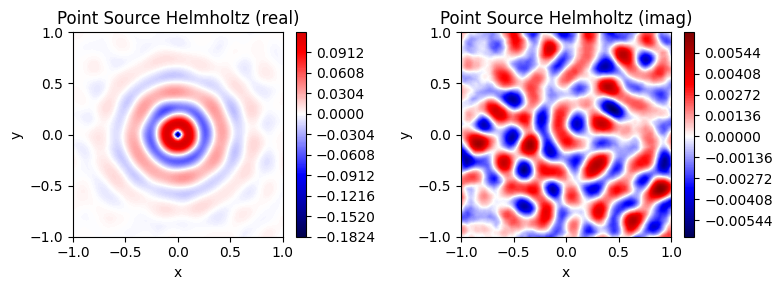

In [36]:
model_pred(model, Lx, Ly)

In [55]:
def plot_cut(model):
    x, y = torch.linspace(0, 0.5, 100), torch.zeros(100)
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    xy = torch.cat([x, y], dim=-1)
    p = model(xy)

    import scipy
    xx = np.linspace(0, 0.5, 100)
    hankel = scipy.special.hankel2(0, 20 * xx) * 0.25j
    plt.plot(x.detach().numpy(), (p[:, 0:1]).detach().numpy(), xx, hankel.real)

/tmp/ipykernel_28292/222225716.py:9: RuntimeWarning: invalid value encountered in multiply
  hankel = scipy.special.hankel2(0, 20 * xx) * 0.25j


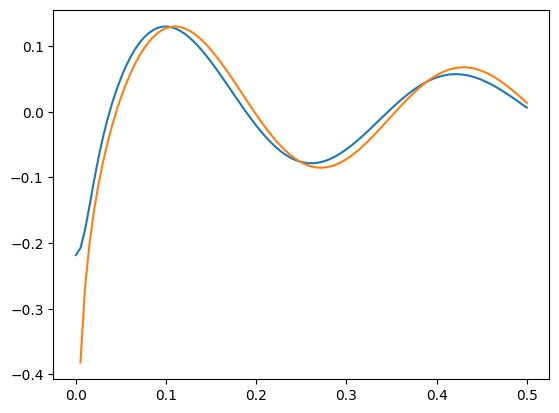

In [56]:
plot_cut(model.to('cpu'))

In [20]:
lamb

[tensor(1.0118, device='cuda:0'), tensor(92.1865, device='cuda:0')]